# Data Transformation and Modeling

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")
from pandas.io.json import json_normalize

In [5]:
df = pd.read_csv('/Users/zhanghaoyan/Documents/DS501/BitTiger-DS501-1702/Projects/神策数据/sensor_data.csv',encoding='utf-8')

/Users/zhanghaoyan/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
users = df['distinct_id'].unique()
new_users = df.loc[df['type']=='profile_set_once','distinct_id'].unique()
users.size,new_users.size

(8259, 6479)

In [7]:
df_new_users = df.loc[df['distinct_id'].isin(new_users),:]
df_new_users.shape

(37181, 37)

In [255]:
condition = (df_new_users['event']=='btnClick')&(df_new_users['properties.name']=='request')
click_request_user = df_new_users.loc[condition,'distinct_id'].unique()

l = []
for m, _ in enumerate(click_request_user):  

    this_user = df_new_users.loc[(df_new_users['distinct_id']==click_request_user[m]),:].sort_values('time')

    # find index of first requst button 
    condition = (this_user['event']=='btnClick')&(this_user['properties.name']=='request')
    ind = this_user.index[condition][0]

    n_this_user = this_user.reset_index()
    ind = n_this_user.loc[n_this_user['index']==ind,:].index[0]
    new_ind = n_this_user.loc[:(ind-1),'index'].values
        
    l = np.append(l,new_ind)

l = l.astype(int)

In [256]:
l.size

3236

In [257]:
condition = (df_new_users['event']<>'btnClick')|(df_new_users['properties.name']<>'request')
other_users = df_new_users.loc[condition,'distinct_id'].unique()
m = []
for i,j in enumerate(other_users):
    n = df_new_users.index[df_new_users['distinct_id'] == j]
    m = np.append(m,n)
m.astype(int)
l = np.append(l,m).astype(int)
l.size

40417

In [258]:
df_clean = df_new_users.loc[l,:]
df_clean.shape

(40417, 37)

Delete Users that only have less than 3 records and they don't have sign up user since that step needs at least four records.

In [259]:
user_less_records = df_clean['distinct_id'].value_counts().index[df_clean['distinct_id'].value_counts()<3]
user_more_records = df_clean['distinct_id'].value_counts().index[df_clean['distinct_id'].value_counts()>3]
len(user_less_records) # There are 1841 user with less than 3 records
# in these users there is not our target user
(df_clean.loc[(df_clean['distinct_id'].isin(user_less_records)) & (df_clean['event']=='formSubmit') & (df_clean['properties.isSuccess']==True),'distinct_id'].value_counts()).sum()

0

In [260]:
df_clean=df_clean.loc[df_clean['distinct_id'].isin(user_more_records),:]

In [261]:
df_clean.shape

(30992, 37)

In [48]:
df_clean.to_csv('/Users/zhanghaoyan/Documents/DS501/BitTiger-DS501-1702/Projects/神策数据/sensor_data_df_clean.csv',encoding='utf-8')

In [2]:
df_clean = pd.read_csv('/Users/zhanghaoyan/Documents/DS501/BitTiger-DS501-1702/Projects/神策数据/sensor_data_df_clean.csv',encoding='utf-8')

In [8]:
index = df_clean['distinct_id'].unique()
metric = pd.DataFrame(index = index)
target = pd.DataFrame(np.array(0).repeat(len(metric)),index = index,columns=['target'])
for i,j in enumerate(target.index):
    if not (df_new_users.loc[(df_new_users['event']=='formSubmit') & \
                     (df_new_users['properties.isSuccess']==True)&(df_new_users['distinct_id']==j),:]).empty:
        target.loc[j,'target'] = 1
target = pd.DataFrame(target,columns=['target'])

In [10]:
target.shape

(2710, 1)

In [11]:
target.loc[target['target'] == 1,:].sum()

target    255
dtype: int64

Construct features

Pageview_count

direct_search_count: pageview referrer 是空值说明是直接输入地址搜索
    
    other referrer host (dummies?)
     u'www.sensorsdata.cn', u'www.baidu.com', u'www.sogou.com',
       u'link.zhihu.com', u'ebizdemo.cloud.sensorsdata.cn',
       u'www.google.com.ph', u'm.baidu.com', u'm.sogou.com',
       u'wenku.baidu.com', u'm5.baidu.com', u'wap.sogou.com',
       u'zhidao.baidu.com', u'www.google.com.hk', u'hippter.com',
       u'www.google.nl', u'googleads.g.doubleclick.net', u'sensorsdata.cn',
       u'www.google.com', u'class.sanjieke.cn', u'www.ecdaohang.cn',
       u'www.so.com', u'youxuan.baidu.com', u'www.tisiwi.com',
       u'zhishi.sogou.com', u'www.woshipm.com', u'36kr.com',
       u'segmentfault.com', u'newseed.pedaily.cn', u'image.baidu.com',
       u'www.google.co.uk', u'shouce.kuchuan.com', u'www.itjuzi.com',
       u'so.m.sm.cn', u'wisd.sogou.com', u'www.linear.vc',
       u'www.google.co.jp', u'a.mobi.sogou.com', u'www.digitaling.com',
       u'www.3lian.com', u'hao.199it.com', u'mail.qq.com',
       u'passport.36kr.com', u'www.zhaosaas.com', u'cn.bing.com',
       u'192.168.3.130', u'sawiki2.nie.netease.com', u'tieba.baidu.com',
       u'shimo.im', u'www.rinterest.cn', u'www.appganhuo.com',
       u'cpro.baidu.com
       
 
stay_length for each page:
    
    stay_length_index
    stay_length_demo
    stay_length_courses
    stay_length_courses_play
    stay_length_about
    stay_length_page_close

utm_source : u'baidu', u'sogou', u'google', u'sanjieke.cn', u'wechat'
    
    source_baidu
    source_sogou
    source_google
    source_sanjieke
    source_wechat

In [492]:
(df_clean['properties.$url_path'].value_counts().index[(df_clean['properties.$url_path'].value_counts()>=9)])

Index([u'/', u'/demo.html', u'/product.html', u'/manual/', u'/b-round.html',
       u'/about.html', u'/index.html', u'/courses/', u'/courses/play.html',
       u'/manual/index.html', u'/courses/index.html', u'/manual/js_sdk.html',
       u'/manual/eb_case.html', u'/manual/use_steps.html',
       u'/manual/data_model.html', u'/manual/event_ana.html',
       u'/manual/data_schema.html', u'/manual/data_import.html',
       u'/manual/user_identify.html', u'/tools/code_auto/',
       u'/manual/android_sdk.html', u'/manual/ios_sdk.html',
       u'/manual/vtrack_intro.html', u'/manual/edu_case.html',
       u'/manual/user_access_path_ana.html', u'/manual/php_sdk.html',
       u'/manual/b2b_homepage_case.html', u'/manual/data_management.html',
       u'/manual/funnel.html'],
      dtype='object')

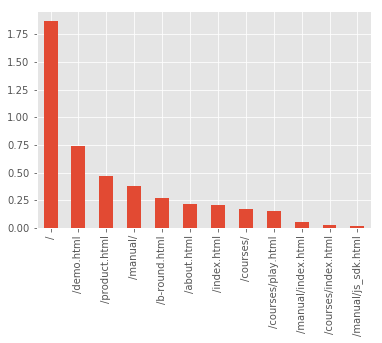

In [514]:
((df_clean['properties.$url_path'].value_counts()[:12])/float(df_clean['distinct_id'].unique().size)).plot(kind='bar')

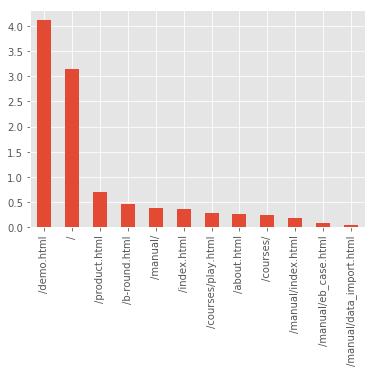

In [511]:
formSubmit_user = df_clean.loc[(df_clean['event']=='formSubmit')&(df_clean['properties.isSuccess']==True),'distinct_id'].unique()
((df_clean.loc[df_clean['distinct_id'].isin(formSubmit_user),'properties.$url_path'].value_counts()[:12])/float(formSubmit_user.size)).plot(kind='bar')



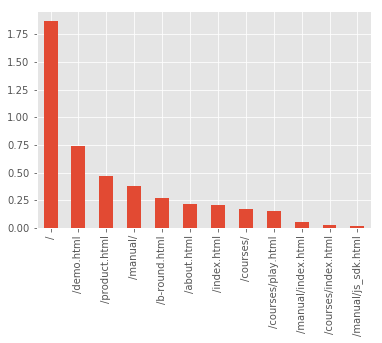

In [515]:
other_user = df_clean.loc[(df_clean['event']<>'formSubmit'),'distinct_id'].unique()
((df_clean.loc[df_clean['distinct_id'].isin(other_user),'properties.$url_path'].value_counts()[:12])/float(other_user.size)).plot(kind='bar')

In [12]:
def count(condition):
    return df_clean.loc[condition,:].groupby('distinct_id')['distinct_id'].count()

In [390]:
pageview_count = count(df_clean[u'event']==u'$pageview')
                                                                      
index_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/'))
demo_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/demo.html'))
product_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/product.html'))
manual_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/'))
b_round_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/b-round.html'))
index_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/index.html'))
about_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/about.html'))
courses_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/courses/'))
courses_play_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/courses/play.html'))
manual_index_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/index.html'))
courses_index_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/courses/index.html'))
manual_js_sdk_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/js_sdk.html'))
manual_data_model_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/data_model.html'))
manual_use_steps_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/use_steps.html'))
manual_eb_case_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/eb_case.html'))
manual_event_ana_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/event_ana.html'))
manual_android_sdk_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/android_sdk.html'))
manual_vtrack_intro_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/vtrack_intro.html'))
manual_data_schema_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/data_schema.html'))
manual_data_import_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/data_import.html'))
manual_user_identify_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/user_identify.html'))
manual_funnel_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/funnel.html'))
manual_user_identify_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/user_identify.html'))
manual_user_identify_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/user_identify.html'))
manual_user_identify_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/manual/user_identify.html'))
tools_code_auto_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path']=='/tools/code_auto/'))
other_view_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$url_path'].isin\
                                                             (df_clean['properties.$url_path'].value_counts().\
                                                              index[(df_clean['properties.$url_path'].value_counts()<9)])))

direct_search_count = count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$referrer_host'].isnull()))
refer_host_list = []
for refer_host in df_clean[u'properties.$referrer_host'].unique():
    a=count((df_clean[u'event']==u'$pageview')&(df_clean[u'properties.$referrer_host'])==i)
    refer_host_list.append(a)

condition = df[u'event']==u'index_leave'
stay_length_index = df_clean.loc[condition,:].groupby(u'distinct_id')[u'properties.pageStayTime'].sum()
condition = df[u'event']==u'demo_leave'
stay_length_demo = df_clean.loc[condition,:].groupby(u'distinct_id')[u'properties.pageStayTime'].sum()
condition = df[u'event']==u'courses_leave'
stay_length_courses = df_clean.loc[condition,:].groupby(u'distinct_id')[u'properties.pageStayTime'].sum()
condition = df[u'event']==u'courses_play_leave'
stay_length_courses_play = df_clean.loc[condition,:].groupby(u'distinct_id')[u'properties.pageStayTime'].sum()
condition = df[u'event']==u'about_leave'
stay_length_about = df_clean.loc[condition,:].groupby(u'distinct_id')[u'properties.pageStayTime'].sum()
condition = df[u'event']==u'page_close'
stay_length_page_close = df_clean.loc[condition,:].groupby(u'distinct_id')[u'properties.pageStayTime'].sum()

condition = df[u'properties.$latest_utm_source']==u'baidu'
a = df_clean.loc[condition,'distinct_id']
a.drop_duplicates(keep = 'first', inplace = True)
source_baidu = pd.DataFrame(data = np.array(1).repeat(len(a)),index=a,columns=['baidu'])

condition = df[u'properties.$latest_utm_source']==u'sogou'
a = df_clean.loc[condition,'distinct_id']
a.drop_duplicates(keep = 'first', inplace = True)
source_sogou = pd.DataFrame(data = np.array(1).repeat(len(a)),index=a,columns=['sogou'])

condition = df[u'properties.$latest_utm_source']==u'google'
a = df_clean.loc[condition,'distinct_id']
a.drop_duplicates(keep = 'first', inplace = True)
source_google = pd.DataFrame(data = np.array(1).repeat(len(a)),index=a,columns=['google'])

condition = df[u'properties.$latest_utm_source']==u'sanjieke.cn'
a = df_clean.loc[condition,'distinct_id']
a.drop_duplicates(keep = 'first', inplace = True)
source_sanjieke = pd.DataFrame(data = np.array(1).repeat(len(a)),index=a,columns=['sanjieke.cn'])

condition = df[u'properties.$latest_utm_source']==u'wechat'
a = df_clean.loc[condition,'distinct_id']
a.drop_duplicates(keep = 'first', inplace = True)
source_wechat = pd.DataFrame(data = np.array(1).repeat(len(a)),index=a,columns=['wechat'])


In [406]:
list1 =  ['a','b','c']
list1.append('c')

In [435]:
result = pd.concat([metric,index_view_count,demo_view_count,\
                   product_view_count,manual_view_count, b_round_view_count, index_view_count,\
                   about_view_count,courses_view_count,courses_play_view_count,manual_index_view_count,\
                   courses_index_view_count,manual_js_sdk_view_count,manual_data_model_view_count,\
                    manual_use_steps_view_count,manual_eb_case_view_count,manual_event_ana_view_count,\
                   manual_android_sdk_view_count,manual_vtrack_intro_view_count,manual_data_schema_view_count,\
                   manual_data_import_view_count,manual_user_identify_view_count,manual_funnel_view_count,\
                   manual_user_identify_view_count,manual_user_identify_view_count,manual_user_identify_view_count,\
                   tools_code_auto_view_count,direct_search_count,\
                   stay_length_index,stay_length_demo, stay_length_courses, stay_length_courses_play,\
                   stay_length_about,stay_length_page_close,\
                   source_baidu,source_sogou,source_google,source_sanjieke,source_wechat], axis=1, join='outer')
    
    
result_col = ['index_view_count','demo_view_count',\
                   'product_view_count','manual_view_count', 'b_round_view_count', 'index_view_count',\
                   'about_view_count','courses_view_count','courses_play_view_count','manual_index_view_count',\
                   'courses_index_view_count','manual_js_sdk_view_count','manual_data_model_view_count',\
                    'manual_use_steps_view_count','manual_eb_case_view_count','manual_event_ana_view_count',\
                   'manual_android_sdk_view_count','manual_vtrack_intro_view_count','manual_data_schema_view_count',\
                   'manual_data_import_view_count','manual_user_identify_view_count','manual_funnel_view_count',\
                   'manual_user_identify_view_count','manual_user_identify_view_count','manual_user_identify_view_count',\
                   'tools_code_auto_view_count','direct_search_count','stay_length_index','stay_length_demo',\
                     'stay_length_courses', 'stay_length_courses_play','stay_length_about','stay_length_page_close',\
                     'source_baidu','source_sogou','source_google','source_sanjieke','source_wechat']

for i,j in enumerate(refer_host_list):
    result = pd.concat([result,j],axis =1, join = 'outer')
    result_col.append('refer_host_%s' %df_clean[u'properties.$referrer_host'].unique()[i])
    
result.columns = result_col
result.fillna(0,inplace=True)

In [436]:
result.shape

(2710, 152)

In [448]:
result_col

['index_view_count',
 'demo_view_count',
 'product_view_count',
 'manual_view_count',
 'b_round_view_count',
 'index_view_count',
 'about_view_count',
 'courses_view_count',
 'courses_play_view_count',
 'manual_index_view_count',
 'courses_index_view_count',
 'manual_js_sdk_view_count',
 'manual_data_model_view_count',
 'manual_use_steps_view_count',
 'manual_eb_case_view_count',
 'manual_event_ana_view_count',
 'manual_android_sdk_view_count',
 'manual_vtrack_intro_view_count',
 'manual_data_schema_view_count',
 'manual_data_import_view_count',
 'manual_user_identify_view_count',
 'manual_funnel_view_count',
 'manual_user_identify_view_count',
 'manual_user_identify_view_count',
 'manual_user_identify_view_count',
 'tools_code_auto_view_count',
 'direct_search_count',
 'stay_length_index',
 'stay_length_demo',
 'stay_length_courses',
 'stay_length_courses_play',
 'stay_length_about',
 'stay_length_page_close',
 'source_baidu',
 'source_sogou',
 'source_google',
 'source_sanjieke',
 's

# Try different models

In [437]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

In [439]:
target = target.target.values
result1 = result.values

In [440]:
def resample(X,y):
    print('Original dataset shape {}'.format(Counter(y)))
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(X, y)
    print('Resample dataset shape {}'.format(Counter(y_res)))
    return X_res, y_res

In [441]:
X, y = resample(result1, target)

Original dataset shape Counter({0: 2455, 1: 255})
Resample dataset shape Counter({0: 2455, 1: 2455})


In [442]:
def scale(x_train, x_test):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
    X_test_scaled = pd.DataFrame(scaler.transform(x_test))
    return X_train_scaled, X_test_scaled

In [443]:
# Helper method to print metric scores
def print_results(y_true, y_pred):
    print("Accuracy of the Logistic Regression is: {}".format(accuracy_score(y_true, y_pred)))
    print("Precision of the Logistic Regression is: {}".format(precision_score(y_true, y_pred)))
    print("Recall of the Logistic Regression is: {}".format(recall_score(y_true, y_pred)))
    print("f1-score of the Logistic Regression is: {}".format(f1_score(y_true, y_pred)))
def results(y_true, y_pred):
    return accuracy_score(y_true, y_pred),precision_score(y_true, y_pred),recall_score(y_true, y_pred),f1_score(y_true, y_pred)

Corss Validation for Logistic Regression

In [444]:
def cross_validation(X,y,n, C = [1,10,100, 10**3, 10**4, 10**5, 10**6] , P = ['l1','l2']):
    
    kf = KFold(n_splits= n)
    
    i = 0
    coeffs_list = []
    y_train_pred_list = []; y_train_list = []; best_lr_list=[]
    y_test_pred_list = []; y_test_list = [] ;y_test_pred_proba_list=[]
    
    for train, test in kf.split(X):
        
        i+=1
        
        X_train = X[train]; X_test = X[test]
        y_train = y[train]; y_test = y[test]
        
        y_train_list.append(y_train), y_test_list.append(y_test)
        
        # Scale by training data
        X_train_scale, X_test_scale = scale(X_train, X_test)
        
        # Logistic Regression. Tune the parameter using grid research of cv5
        parameters = {'C':C, 'penalty':P}
        lr = LogisticRegression(random_state=42)
        gs = GridSearchCV(lr,parameters,scoring = 'roc_auc', cv = 5)
        gs.fit(X_train_scale, y_train)
#         print gs.cv_results_
        
        # Best coeffs
        best_lr = gs.best_estimator_
        best_lr_list.append(best_lr)
        df_coeffs0 = pd.DataFrame(list(zip(result.columns, best_lr.coef_.flatten()))).sort_values(by=[1], ascending=False)
        df_coeffs0.columns = ['feature', 'coeff_cv_%s' %i]
        coeffs_list.append(df_coeffs0)
            
        # Prediction
        y_train_pred_list.append(best_lr.predict(X_train_scale))
        y_test_pred_list.append(best_lr.predict(X_test_scale))
        y_test_pred_proba_list.append(best_lr.predict_proba(X_test_scale)[:,1])
        
    return best_lr_list, coeffs_list, y_train_list , y_train_pred_list, y_test_list, y_test_pred_list

In [445]:
best_lr_list,coeffs_list, y_train_list , y_train_pred_list, y_test_list, y_test_pred_list = \
    cross_validation(X,y,5, C = [1,10,100, 10**3, 10**4, 10**5, 10**6] , P = ['l1','l2'])

In [489]:
def print_mean_score(y_test_list,y_test_pred_list):
    accuracy = []; precision = []; recall = []; f1 = []
    
    for i,(best_lr, y_true, y_pred) in enumerate(zip(best_lr_list, y_test_list,y_test_pred_list)):
    #     print_results(y_true, y_pred)
        a, b, c, d = results(y_true, y_pred)
        accuracy.append(a);precision.append(b);recall.append(c);f1.append(d)
        print 'Result %s : ' %i
        print 'Parameters %s' %(best_lr)
        print 'confusion matrix'
        print 'y true %s y pred %s' %(y_true.sum(),y_pred.sum())
        print(confusion_matrix(y_true, y_pred))
        try:
            print "Area Under Curve (AUC) of the Logistic Regression is: %s" %(roc_auc_score(y_true, y_pred))
        except:
            print 'AUC can not be calculated'
        print 'For accracy %s precision %s recall %s and f1 %s' %(a,b,c,d)
        print '---------------------------------'
        
    print 'Mean Accuracy %s, Mean Precision %s Mean recall %s and Mean f1 %s' %(np.mean(accuracy),np.mean(precision), np.mean(recall), np.mean(f1))
        

In [490]:
print_mean_score(y_test_list,y_test_pred_list)

Result 0 : 
Parameters LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
confusion matrix
y true 216 y pred 841
[[112 654]
 [ 29 187]]
Area Under Curve (AUC) of the Logistic Regression is: 0.505977419979
For accracy 0.304480651731 precision 0.222354340071 recall 0.865740740741 and f1 0.353831598865
---------------------------------
Result 1 : 
Parameters LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
confusion matrix
y true 39 y pred 925
[[ 57 886]
 [  0  39]]
Area Under Curve (AUC) of the Logistic Regression is: 0.530222693531
For accracy 0.0977596741344 precisio

In [324]:
# coeffs_list[4]

# A simple logistic without tune

In [451]:
from sklearn.cross_validation import train_test_split
x_train, x_test, target_train, target_test = train_test_split(
    result1, target, test_size=0.5, random_state=0)

In [452]:
X_train_scale, X_test_scale = scale(x_train, x_test)
X_res, y_res = resample(X_train_scale, target_train)
X_res_test, y_res_test = resample(X_test_scale, target_test)

Original dataset shape Counter({0: 1234, 1: 121})
Resample dataset shape Counter({0: 1234, 1: 1234})
Original dataset shape Counter({0: 1221, 1: 134})
Resample dataset shape Counter({0: 1221, 1: 1221})


In [455]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l1',C=10**4, fit_intercept=True)
lr.fit(X_res, y_res)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [456]:
df_coeffs = pd.DataFrame(list(zip(result.columns, lr.coef_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'coeff']
df_coeffs

,feature,coeff
30,stay_length_courses_play,0.245856
3,manual_view_count,0.183328
25,tools_code_auto_view_count,0.126561
34,source_sogou,0.122657
28,stay_length_demo,0.118229
13,manual_use_steps_view_count,0.102933
36,source_sanjieke,0.086506
14,manual_eb_case_view_count,0.086287
4,b_round_view_count,0.070824
15,manual_event_ana_view_count,0.066752


In [457]:
# Make prediction on the training data
y_train_pred = lr.predict(X_res)

# Make predictions on test data
y_test_pred = lr.predict(X_res_test)

In [458]:
y_train_pred.sum(), y_test_pred.sum()

(1643, 1352)

In [459]:
y_train_pred.size,

(2468,)

In [460]:
print("Training set scores:")
print_results(y_res, y_train_pred)

Training set scores:
Accuracy of the Logistic Regression is: 0.605753646677
Precision of the Logistic Regression is: 0.579427875837
Recall of the Logistic Regression is: 0.771474878444
f1-score of the Logistic Regression is: 0.661800486618


In [461]:
print("Test set scores:")
print_results(y_res_test, y_test_pred)

Test set scores:
Accuracy of the Logistic Regression is: 0.45085995086
Precision of the Logistic Regression is: 0.455621301775
Recall of the Logistic Regression is: 0.504504504505
f1-score of the Logistic Regression is: 0.478818499806


In [462]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
confusion_matrix(y_res, y_train_pred)

array([[543, 691],
       [282, 952]])

In [463]:
confusion_matrix(y_res_test, y_test_pred)

array([[485, 736],
       [605, 616]])

In [464]:
# Helper method to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    '''
    Code from sklearn example.
    '''
    
    cm = confusion_matrix(y_true, y_pred)

    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[543 691]
 [282 952]]


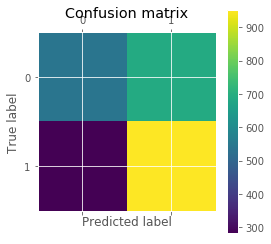

In [465]:
plot_confusion_matrix(y_res, y_train_pred)

[[485 736]
 [605 616]]


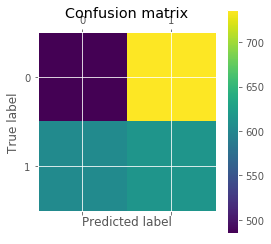

In [466]:
plot_confusion_matrix(y_res_test, y_test_pred)

In [467]:
print("Area Under Curve (AUC) of the Logistic Regression is: {}".format(roc_auc_score(y_res_test, y_test_pred)))

Area Under Curve (AUC) of the Logistic Regression is: 0.45085995086


In [468]:
print(classification_report(y_res_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.44      0.40      0.42      1221
          1       0.46      0.50      0.48      1221

avg / total       0.45      0.45      0.45      2442



In [469]:
# Make predictions of the probability to be "positive"/"sign up"/"1", as compared to "negative"/"not sign up"/"0"
y_test_pred_proba = lr.predict_proba(X_res_test)[:,1]

In [470]:
fpr, tpr, thresholds = roc_curve(y_res_test, y_test_pred_proba)

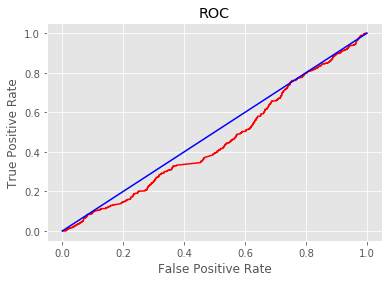

In [471]:
# plot TPR against FPR
plt.plot(fpr, tpr, color='red')

# plot 45 degree line
xx = np.linspace(0, 1.0, 20)
plt.plot(xx, xx, color='blue')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

plt.show()

Random Forest

In [472]:
# Build a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

# To be implemented
model_rfc = RandomForestClassifier(max_depth=None, n_estimators=5, min_samples_leaf=10)

model_rfc.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [473]:
df_feature_importance = pd.DataFrame(list(zip(result.columns, model_rfc.feature_importances_.flatten()))).sort_values(by=[1], ascending=False)
df_feature_importance.columns = ['feature', 'feature importance']
df_feature_importance

,feature,feature importance
2,product_view_count,0.103042
27,stay_length_index,0.090983
28,stay_length_demo,0.051024
34,source_sogou,0.039569
4,b_round_view_count,0.035744
82,refer_host_cn.bing.com,0.035088
26,direct_search_count,0.033373
1,demo_view_count,0.033256
3,manual_view_count,0.030666
75,refer_host_a.mobi.sogou.com,0.024074


In [474]:
y_train_pred = model_rfc.predict(X_res)

In [475]:
print("Training set scores:")
print_results(y_res, y_train_pred)

Training set scores:
Accuracy of the Logistic Regression is: 0.788492706645
Precision of the Logistic Regression is: 0.85814889336
Recall of the Logistic Regression is: 0.691247974068
f1-score of the Logistic Regression is: 0.765709156194


In [476]:
y_test_pred = model_rfc.predict(X_res_test)

In [477]:
print("Training set scores:")
print_results(y_res_test, y_test_pred)

Training set scores:
Accuracy of the Logistic Regression is: 0.633087633088
Precision of the Logistic Regression is: 0.753510140406
Recall of the Logistic Regression is: 0.395577395577
f1-score of the Logistic Regression is: 0.518796992481


In [478]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
confusion_matrix(y_res, y_train_pred)

array([[1093,  141],
       [ 381,  853]])

In [479]:
confusion_matrix(y_res_test, y_test_pred)

array([[1063,  158],
       [ 738,  483]])

[[1093  141]
 [ 381  853]]


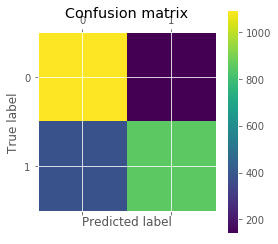

In [480]:
plot_confusion_matrix(y_res, y_train_pred)

[[1063  158]
 [ 738  483]]


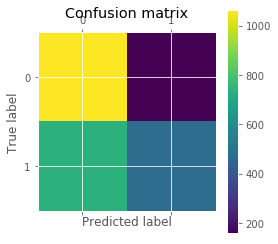

In [481]:
plot_confusion_matrix(y_res_test, y_test_pred)

In [482]:
print("Area Under Curve (AUC) of the Logistic Regression is: {}".format(roc_auc_score(y_res_test, y_test_pred)))

Area Under Curve (AUC) of the Logistic Regression is: 0.633087633088


In [483]:
print(classification_report(y_res_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.59      0.87      0.70      1221
          1       0.75      0.40      0.52      1221

avg / total       0.67      0.63      0.61      2442



In [484]:
# Make predictions of the probability to be "positive"/"sign up"/"1", as compared to "negative"/"not sign up"/"0"
y_test_pred_proba = model_rfc.predict_proba(X_res_test)[:,1]

In [485]:
fpr, tpr, thresholds = roc_curve(y_res_test, y_test_pred_proba)

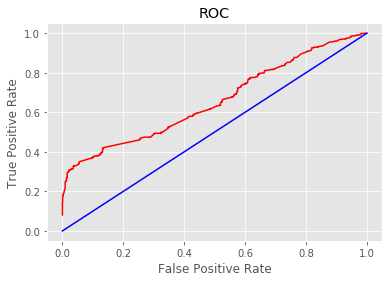

In [486]:
# plot TPR against FPR
plt.plot(fpr, tpr, color='red')

# plot 45 degree line
xx = np.linspace(0, 1.0, 20)
plt.plot(xx, xx, color='blue')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

plt.show()